In [2]:
import sys
sys.path.append('/home/swang597/Documents/Research/Project_heightmap/Utility_projHM')

import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader
# from sklearn.model_selection import train_test_split
import os
import numpy as np
# import tqdm
# import torchvision
# from torchvision import datasets, models, transforms
# import copy

# from sklearn.model_selection import train_test_split
# from sklearn.datasets import fetch_california_housing
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

from datetime import date
# from model_3e3d import UNet_3e3d_Img, UNet_3e3d_Vec, UNet_CNN3e3d_2I_1V, UNet_CNN3e3d_2I_1V_lin2
# import model_3e3d as mymodel
import glob

import trimesh
import h5py

# torch.manual_seed(1)
np.random.seed(1)

viper_cylwheel
Processing degree: 0.00 deg
Processing degree: 36.00 deg
Processing degree: 72.00 deg
Processing degree: 108.00 deg
Processing degree: 144.00 deg
Processing degree: 180.00 deg
Processing degree: 216.00 deg
Processing degree: 252.00 deg
Processing degree: 288.00 deg
Processing degree: 324.00 deg


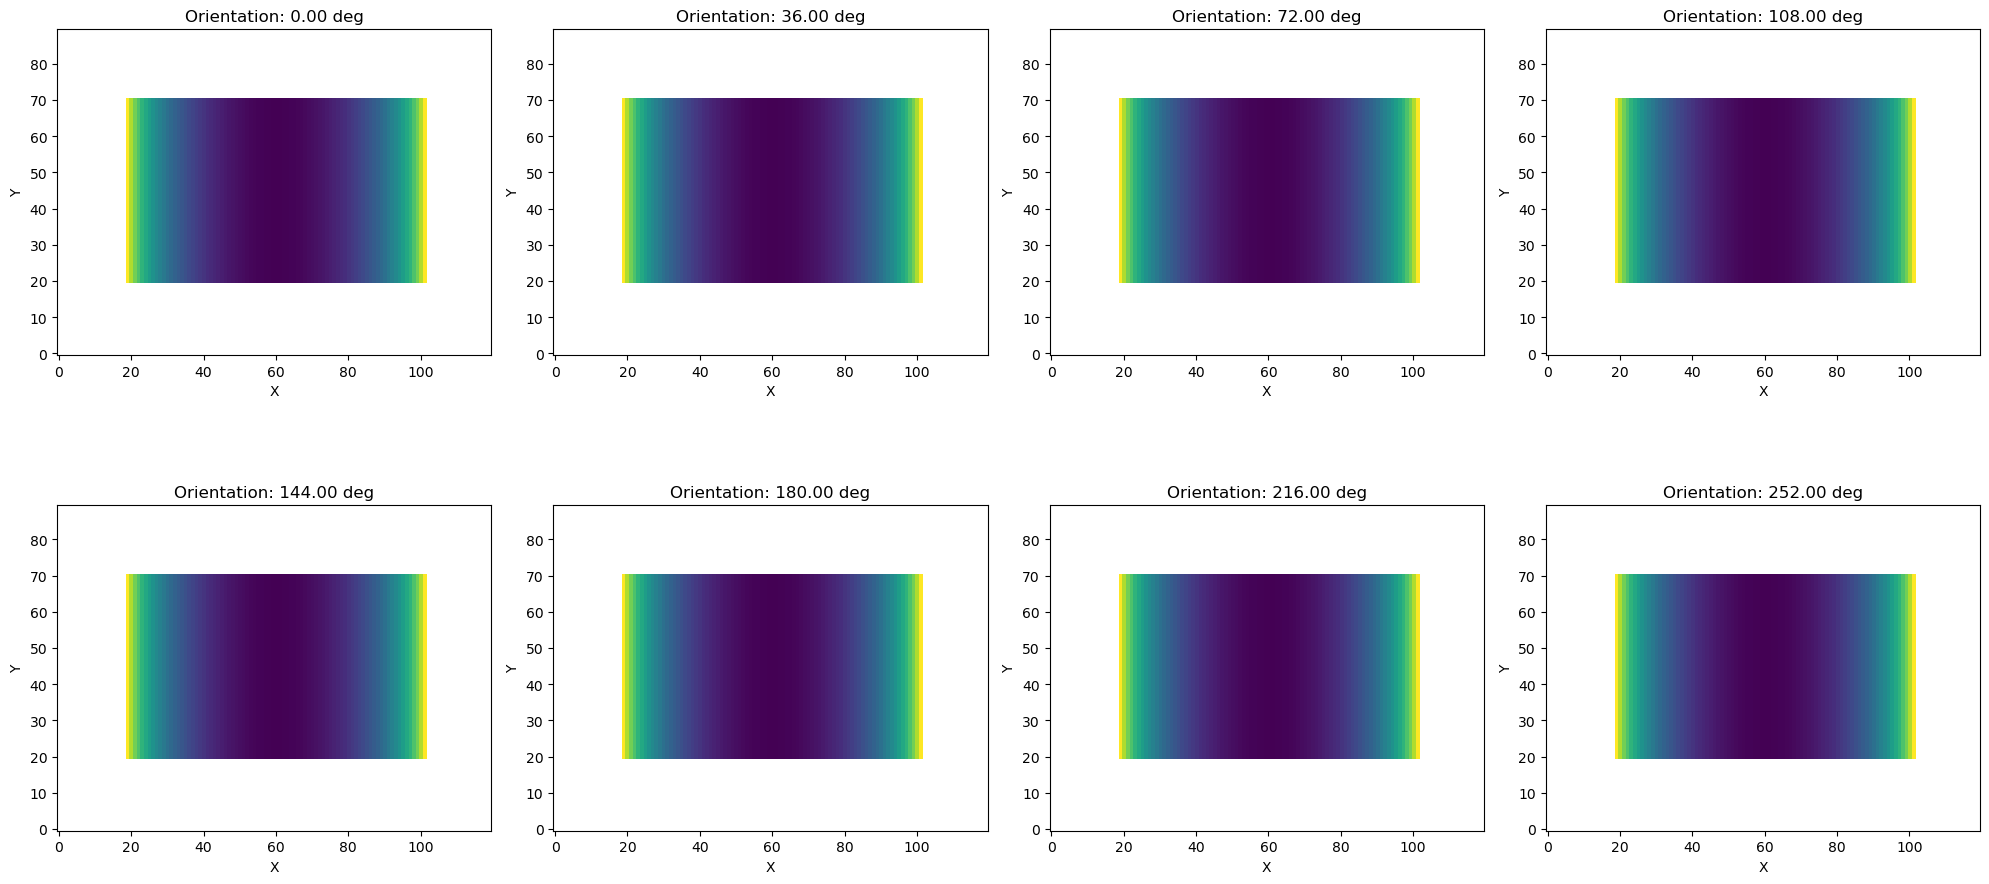

In [3]:
import numpy as np
import trimesh

def barycentric_coordinates(pt, v1, v2, v3):
    """
    Compute barycentric coordinates of pt within the triangle defined by v1, v2, v3.
    """
    mat = np.array([v1-v3, v2-v3, np.cross(v1-v3, v2-v3)])
    inv_mat = np.linalg.inv(mat.T)
    result = np.dot(inv_mat, np.array([pt[0]-v3[0], pt[1]-v3[1], 0]))
    return result[:2], result[2]

def update_height_at_point(x_world, y_world, face, vertices):
    """
    Calculate the Z height of a mesh face at a given X, Y world coordinate.
    """
    v1, v2, v3 = vertices[face]
    bary, _ = barycentric_coordinates([x_world, y_world, 0], v1, v2, v3)
    if np.all(bary >= 0) and np.sum(bary) <= 1:
        # The point is inside the triangle, calculate Z using the plane equation
        z = v1[2] + (v2[2] - v1[2]) * bary[0] + (v3[2] - v1[2]) * bary[1]
        return z
    return None

def apply_mesh_to_height_map_efficient(height_map, obj_file_path, wheel_center, orientation, grid_size):
    """
    Updates a height map based on the projection of a 3D mesh using efficient face lookup.
    """
    # Load the mesh and apply orientation and translation transformations
    mesh = trimesh.load(obj_file_path, force='mesh')
    mesh.apply_transform(trimesh.transformations.euler_matrix(*orientation))
    mesh.apply_translation(wheel_center)

    # Create rays for each point in the height map
    nx, ny = height_map.shape
    origins = np.zeros((nx * ny, 3))
    directions = np.zeros((nx * ny, 3))
    directions[:, 2] = -1  # All rays point downwards in Z-axis

    for i in range(nx):
        for j in range(ny):
            x_world = j * grid_size - (ny / 2 * grid_size) + wheel_center[0]
            y_world = i * grid_size - (nx / 2 * grid_size) + wheel_center[1]
            origins[i * ny + j, :2] = [x_world, y_world]

    # Perform ray-mesh intersection test
    locations, index_ray, index_tri = mesh.ray.intersects_location(
        ray_origins=origins,
        ray_directions=directions
    )

    # Update the height map based on the intersections
    for loc, idx_ray in zip(locations, index_ray):
        i, j = divmod(idx_ray, ny)
        height_map[i, j] = min(height_map[i, j], loc[2])

# Example usage
# obj_file_path = '/home/swang597/Documents/Research/chrono_fork_radu/data/robot/viper/obj/viper_wheel.obj'
# obj_file_path = '/home/swang597/Documents/Research/chrono_fork_radu/data/robot/viper/obj/viper_simplewheel.obj'
obj_file_path = '/home/swang597/Documents/Research/chrono_fork_radu/data/robot/viper/obj/viper_cylwheel.obj'
keywords = obj_file_path.split('/')[-1][:-4]
print(keywords)
wheel_center = np.array([0, 0, 0])  # Adjust as needed
grid_size = 0.005  # Adjust as needed
rotation_degrees = [i for i in range(0,360,36)]#[0, 45, 90, 135, 180, 225, 270, 315]
# Initialize a dictionary to store the height maps keyed by orientation
height_maps = {}

# Compute and store the height map for each orientation
for degree in rotation_degrees:
    print(f'Processing degree: {degree:.2f} deg')
    height_map = np.full((90, 120), np.inf)  # Initialize with large values
    orientation = [0, np.radians(degree), 0]
    apply_mesh_to_height_map_efficient(height_map, obj_file_path, wheel_center, orientation, grid_size)
    height_maps[degree] = height_map


# plot the height maps
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i, (degree, height_map) in enumerate(height_maps.items()):
    if i == 8:
        break
    ax = axs[i // 4, i % 4]
    ax.imshow(height_map, cmap='viridis', origin='lower')
    ax.set_title(f'Orientation: {degree:.2f} deg')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
plt.tight_layout()
plt.show()



In [25]:
print(min(height_map.flatten()), max(height_map.flatten()))
print(height_map.shape, len(height_map[:,60]),height_map[:21,60])
print(height_map[19:72,60])



-0.20799909466235325 inf
(90, 120) 90 [        inf         inf         inf         inf         inf         inf
         inf         inf         inf         inf         inf         inf
         inf         inf         inf         inf         inf         inf
         inf         inf -0.20799909]
[        inf -0.20799909 -0.20799909 -0.20799909 -0.20799909 -0.20799909
 -0.20799909 -0.20799909 -0.20799909 -0.20799909 -0.20799909 -0.20799909
 -0.20799909 -0.20799909 -0.20799909 -0.20799909 -0.20799909 -0.20799909
 -0.20799909 -0.20799909 -0.20799909 -0.20799909 -0.20799909 -0.20799909
 -0.20799909 -0.20799909 -0.20799909 -0.20799909 -0.20799909 -0.20799909
 -0.20799909 -0.20799909 -0.20799909 -0.20799909 -0.20799909 -0.20799909
 -0.20799909 -0.20799909 -0.20799909 -0.20799909 -0.20799909 -0.20799909
 -0.20799909 -0.20799909 -0.20799909 -0.20799909 -0.20799909 -0.20799909
 -0.20799909 -0.20799909 -0.20799909 -0.20799909         inf]


In [7]:
# Save the data to an HDF5 file
# folder_write = '/home/swang597/Documents/Research/Project_heightmap/Data_sinkage_preproc/'
folder_write = '/home/swang597/Documents/Research/chrono_fork_rserban/Project_TireTestRig/Data_sinkage_preproc/'
if not os.path.exists(folder_write):
    os.makedirs(folder_write)
filename_write = folder_write + 'singkage_'+keywords+'.h5'
with h5py.File(filename_write, 'w') as file:
    for degree, height_map in height_maps.items():
        # Each dataset is named by its orientation for easy identification
        dataset_name = f'degree_{degree}'
        print(f'Saving dataset: {dataset_name}')
        file.create_dataset(dataset_name, data=height_map)

Saving dataset: degree_0
Saving dataset: degree_36
Saving dataset: degree_72
Saving dataset: degree_108
Saving dataset: degree_144
Saving dataset: degree_180
Saving dataset: degree_216
Saving dataset: degree_252
Saving dataset: degree_288
Saving dataset: degree_324
